In [12]:
%%writefile model.py
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Lambda, Cropping2D, Dropout

def read_csv(root_path):
    with open(root_path + 'driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            yield line

def make_local_path(path, local_root):
    basename = path.split('/')[-1]
    return local_root + 'IMG/' + basename

def read_data(data_path):
    samples = []
    for line in read_csv(data_path):
        images = [make_local_path(p, data_path) for p in line[0:3]]
        steering_angle = float(line[3])
        samples.append((images, steering_angle))
                
    return samples

def baseline_mse(samples):
    angles = np.array([s[1] for s in samples])
    return np.mean(np.square(angles - np.mean(angles)))

def augment_with_side_cameras(samples, angle_correction=0):
    new_samples = []
    for images, angle in samples:
        center, left, right = images
        new_samples.append((center, angle))
        if angle_correction > 0:
            new_samples.append((left, angle + angle_correction))
            new_samples.append((right, angle - angle_correction))
    return new_samples

def read_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while True: 
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for img_path, angle in batch_samples:
                images.append(read_image(img_path))
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

data_path = './driving-training/'
angle_correction = 0.3

samples = read_data(data_path)
print("Dataset size: %d" % len(samples))

train_samples, valid_samples = train_test_split(samples, test_size=0.3, random_state=0)

train_samples = augment_with_side_cameras(train_samples, angle_correction)
valid_samples = augment_with_side_cameras(valid_samples, 0)

print("Training set size: %d" % len(train_samples))
print("Validation set size: %d" % len(valid_samples))

base_mse = baseline_mse(valid_samples)
print("Baseline MSE: %.3f" % base_mse)


image_shape = (160, 320, 3)
cropping = ((60, 0), (0, 0))
dropout_rate = 0
batch_size = 128

normalize = lambda x: (x - 127.0) / 127.0

model = Sequential()
model.add(Lambda(normalize, input_shape=image_shape))
model.add(Cropping2D(cropping=cropping))
model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))

model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(generator(train_samples, batch_size), len(train_samples) // batch_size, 
                             validation_data=generator(valid_samples, batch_size), 
                             validation_steps=(len(valid_samples) // batch_size), 
                             epochs = 3)

model.save('model.h5')



Overwriting model.py


(0, 0.093991746452248295)

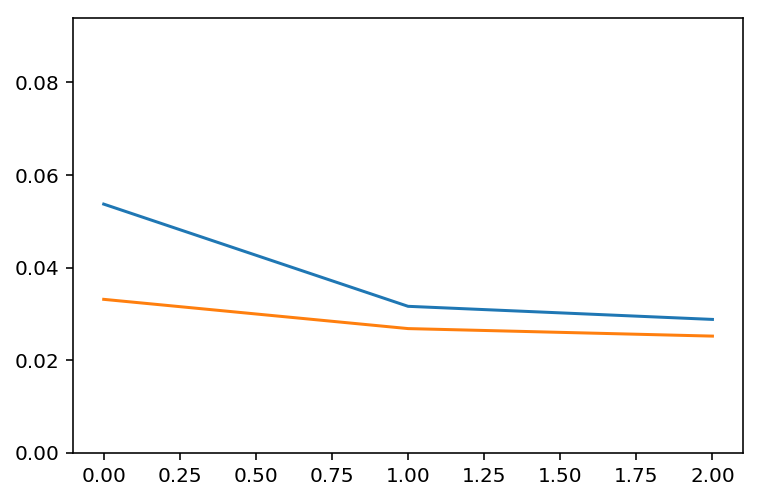

In [44]:
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.ylim(0, base_mse)

In [98]:
history = model.fit_generator(generator(train_samples, batch_size), len(train_samples) // batch_size, 
                             validation_data=generator(valid_samples, batch_size), 
                             validation_steps=(len(valid_samples) // batch_size), 
                             epochs = 3)

model.save('model.h5')

Epoch 1/3
38/38 [==============================] - 21s - loss: 0.0738 - val_loss: 0.0817

In [83]:
model.layers[7].output_shape

(None, 3, 31, 64)

In [8]:
i = read_image(train_samples[0][0])

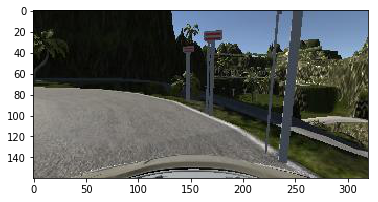

In [9]:
%matplotlib inline
plt.imshow(i)